In [14]:
#BASE LAYER
class Layer:
    def __init__(self):
        self.input = None   
        self.output = None
        #for convinience so that other layers don't have to declare them

    def forward(self, input):
        pass
        #return output

    def backward(self, output_gradient, learning_rate):
        pass
        #to update parameters and return input gradient
        

In [15]:
#DENSE LAYER
import numpy as np

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
        #the constructor takes 2 parameters, number of neurons in the input and output respectively
        
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
    
    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T) #weights gradient formula and bias(output gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient  #we are updating them
        return np.dot(self.weights.T, output_gradient)  #we are returning the derivative of the error with respect to the input

In [16]:
#ACTIVATION LAYER
import numpy as np

class Activation(Layer):  
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))
    

In [17]:
#ACTIVATION FUNCTIONS
import numpy as np

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [18]:
#CNN 
import numpy as np
from scipy import signal

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [19]:
import numpy as np

class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [20]:
import numpy as np

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [21]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils


def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit] # we get the indices of images representing 1 or zero
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))  # we stack these arrays of numbers and shuffle them
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]  #then we extract only the images of these indices
    x = x.reshape(len(x), 1, 28, 28)  #reshape the images to 3d block of 1,28,28 because cnn takes 3d block data
    x = x.astype("float32") / 255   #normalizing them
    y = np_utils.to_categorical(y)  #
    y = y.reshape(len(y), 2, 1)
    return x, y

# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

# test
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

1/20, error=0.40823724862031013
2/20, error=0.11323990382103538
3/20, error=0.09585748136079074
4/20, error=0.04373075648374737
5/20, error=0.03274895740479862
6/20, error=0.030355561902155857
7/20, error=0.013136993028687342
8/20, error=0.011380653115032613
9/20, error=0.00965248743294054
10/20, error=0.007188836649326755
11/20, error=0.005649093301256617
12/20, error=0.005048550177644563
13/20, error=0.004579867289884482
14/20, error=0.004214119953001179
15/20, error=0.00391174950596153
16/20, error=0.0036567545597368627
17/20, error=0.003436257487719728
18/20, error=0.0032417719844065277
19/20, error=0.0030673855636564186
20/20, error=0.002909065973894412
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, t

In [22]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

1/1000, error=1.0411621019073363
2/1000, error=0.6906811160664242
3/1000, error=0.4330903635846045
4/1000, error=0.43060442910956676
5/1000, error=0.4272600731521651
6/1000, error=0.42344343904127013
7/1000, error=0.41942836948741435
8/1000, error=0.41533060766926194
9/1000, error=0.41119136370219334
10/1000, error=0.40702373462041064
11/1000, error=0.4028291738496447
12/1000, error=0.39860196988090285
13/1000, error=0.39432994253749054
14/1000, error=0.3899941752238292
15/1000, error=0.3855686061514778
16/1000, error=0.38101970525725737
17/1000, error=0.3763063596132528
18/1000, error=0.37138015579117456
19/1000, error=0.3661863825171961
20/1000, error=0.36066624743465714
21/1000, error=0.3547609746288084
22/1000, error=0.3484185520067442
23/1000, error=0.3416037825225417
24/1000, error=0.3343117189587881
25/1000, error=0.32658323811629886
26/1000, error=0.3185193093871925
27/1000, error=0.31028793351851974
28/1000, error=0.3021164291944633
29/1000, error=0.294264339075453
30/1000, er

781/1000, error=0.18193914423154728
782/1000, error=0.1819360402914037
783/1000, error=0.18193294458101233
784/1000, error=0.18192985706687642
785/1000, error=0.18192677771568502
786/1000, error=0.1819237064943109
787/1000, error=0.18192064336980932
788/1000, error=0.1819175883094179
789/1000, error=0.18191454128055287
790/1000, error=0.18191150225081093
791/1000, error=0.1819084711879652
792/1000, error=0.18190544805996592
793/1000, error=0.18190243283493834
794/1000, error=0.18189942548118174
795/1000, error=0.1818964259671681
796/1000, error=0.1818934342615408
797/1000, error=0.18189045033311424
798/1000, error=0.1818874741508712
799/1000, error=0.18188450568396364
800/1000, error=0.18188154490170905
801/1000, error=0.1818785917735921
802/1000, error=0.18187564626926128
803/1000, error=0.18187270835852862
804/1000, error=0.18186977801136894
805/1000, error=0.1818668551979183
806/1000, error=0.18186393988847244
807/1000, error=0.18186103205348694
808/1000, error=0.18185813166357473
8

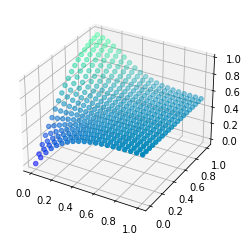

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

# train
train(network, mse, mse_prime, X, Y, epochs=1000, learning_rate=0.1)

# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()